# Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'
from pathlib import Path
from typing import Union, Optional, Literal, Callable
from time import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.rc('figure', figsize=(12,8))
plt.rc('lines', markersize=4)
plt.rc('font', size=30)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=20)
plt.rcParams["figure.autolayout"] = True

from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
from sklearn.utils.validation import check_is_fitted

# Utility functions

Simple timer decorator in order to track the execution time of callables

In [2]:
def _timer(func:Callable) -> Callable:
    """Calculates the execution time of a function.

    Args:
        func (_type_): function to be timed.
    """    
    def wrap_func(*args, **kwargs) -> Callable:
        t1: float = time()
        result: Callable = func(*args, **kwargs)
        t2: float = time()
        print(f'Function {func.__name__!r} executed in {int(t2-t1)}s')
        return result
    return wrap_func

Save objects using joblib. Note that files can become very big very fast.

In [3]:
def save_object(obj: object, path: Path) -> str | None:
    """Saves an object as a joblib file.

    Args:
        obj (object): Object to be saved.
        path (Path): Path of the object.

    Returns:
        str | None
    """    
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("wb") as outp:  # Overwrites any existing file.
        joblib.dump(obj, outp)

In [4]:
def load_object(path: Path) -> str | None| object:
    """Loads an existing joblib file.

    Args:
        path (Path): Path of the joblic file.

    Returns:
        str | None: object
    """
    if not path.exists():
        return f"{path=} does not exist"
    with path.open("rb") as file:
        obj = joblib.load(file)
    if isinstance(obj, object):
        return obj
    return f"obj loaded from {path=} is not of class object."

In [5]:
def cls_fit_info(cls:BaseEstimator) -> str | pd.DataFrame | None:
    """Shows the weight and number of support vectors for the classes of a classifier.
    
    Args:
        cls (BaseEstimator): Cls can be any instance of sklearn models. Works best with SVM instances and alike.

    Returns:
        list[pd.DataFrame]: A dataframe with classes as columns, and rows as classes, weight, n_support,
    """
    if not isinstance(cls, BaseEstimator):
        return f'Model: {cls=} is not a BaseEstimator instance.'
    try:
        check_is_fitted(cls) #returns none if cls is fitted
    except Exception as e:
        print(f'{e=}')
    else:
        return pd.DataFrame.from_dict(
            dict(
                classes = cls.classes_,
                class_weight = cls.class_weight_,
                n_support = cls.n_support_
            )
        ).T.astype(int)

In [59]:
def estimator_info(estimator, y, y_train, y_test) -> pd.DataFrame:
    _dict = {
        'y':{
            'fraud':y.value_counts()[1],
            'normal':y.value_counts()[0],
            'fraud/normal':round(y.value_counts()[1]*100/y.value_counts()[0],2),
            'rows':len(y)
            }, 
        'y_train':{
            'fraud':y_train.value_counts()[1],
            'normal':y_train.value_counts()[0],
            'fraud/normal':round(y_train.value_counts()[1]*100/y_train.value_counts()[0],2),
            'rows':len(y_train)
            },
        'y_test':{
            'fraud':y_test.value_counts()[1],
            'normal':y_test.value_counts()[0],
            'fraud/normal':round(y_test.value_counts()[1]*100/y_test.value_counts()[0],2),
            'rows':len(y_test)
            }
    }
    return pd.concat([pd.DataFrame.from_dict(_dict).T, cls_fit_info(estimator).drop('classes').rename({0:'normal', 1:'fraud'}, axis=1)])

Metrics for classification

In [57]:
def _metrics_calc(y_test, y_pred) -> list[pd.DataFrame]:
    Metrics = {
        "Accuracy":metrics.accuracy_score(y_test, y_pred),
        "Precision":metrics.precision_score(y_test, y_pred),
        "Recall":metrics.recall_score(y_test, y_pred),
        "f1":metrics.f1_score(y_test, y_pred),
        "Bal Accuracy":metrics.balanced_accuracy_score(y_test, y_pred),
        "Av Precision":metrics.average_precision_score(y_test, y_pred),
        "AUC":metrics.roc_auc_score(y_test, y_pred),
        "Matthews CC":metrics.matthews_corrcoef(y_test, y_pred),
        "Cohen KS":metrics.cohen_kappa_score(y_test, y_pred),
    }
    Metrics = {k:[v] for k,v in Metrics.items()}
    Metrics = pd.DataFrame.from_dict(Metrics).T.rename({0:''}, axis=1).rename_axis('Cls Metrics').round(2)
    Metrics_per_class = pd.DataFrame(metrics.precision_recall_fscore_support(y_test, y_pred)).rename({0:'Precision', 1:'Recall', 2:'f1', 3:'Support'}).rename_axis('Cls Metrics Per Class').round(2)
    return [Metrics, Metrics_per_class]

In [56]:
def _metrics_plot(cls:BaseEstimator, X_test:pd.DataFrame, y_test:pd.DataFrame, filename:Optional[str]=None) -> plt.Figure:
    """Plots in a grid, the ROC Curve the Precision-Recall Curve and the Confusion Matrix of a classifier.

    Args:
        cls (BaseEstimator): A trained classifier.
        X_test (pd.DataFrame): Independent test data.
        y_test (pd.DataFrame): Dependent test data.

    Returns:
        plt.Figure: A plt.subplot figure object containing 3 plots(ROC,PRC,Conf Matrix)
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 6));
    metrics.RocCurveDisplay.from_estimator(cls, X_test, y_test, ax=axes[0]);
    axes[0].plot([0,1], [0,1], '--r', label='random cls');
    metrics.PrecisionRecallDisplay.from_estimator(cls, X_test, y_test, ax=axes[1]);
    axes[1].plot([0,1], [0.5,0.5], '--r', label='random cls');
    metrics.ConfusionMatrixDisplay.from_estimator(cls, X_test, y_test, ax=axes[2]);
    axes[0].legend();
    axes[1].legend();
    if (filename:=filename or None):
        save_object(path=Path(f'classifiers/{filename}.joblib'), obj=fig)
    return fig

A note on our metrics_calc and metrics_plot functions:

These functions will be crucial in evaluating our models. Not all metrics have the same importance when dealing with imbalanced classes as we will see.

The most important metrics are those that either work better with large data or somehow take into account the imbalance in data. These include **balanced_accuracy_score**, **average_precision_score**, **precision_recall_fscore_support**, **cohen_kappa_score** and **matthews_corrcoef**. The rest metrics are included for the sake of completeness and contrast.

- **accuracy_score:** the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
---
- **precision_score:** The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. 
  - A measure of a classifiers exactness.
  - The best value is 1 and the worst value is 0.
---
- **recall_score:** The recall is intuitively the ability of the classifier to find all the positive samples.
  - A measure of a classifiers completeness.
  - The best value is 1 and the worst value is 0.
---
- **f1_score:** The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.
---
- **balanced_accuracy_score:** The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class. The best value is 1 and the worst value is 0 when
---
- **average_precision_score:** Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.
---
- **roc_auc_score:** Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
---
- **precision_recall_fscore_support:** Computes precision, recall, F-measure and support for each class.
---
- **cohen_kappa_score:** Classification accuracy normalized by the imbalance of the classes in the data.
  - The kappa score is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).
---
- **matthews_corrcoef:** Is a measure of the quality of binary and multiclass classifications. A balanced measure which can be used even if the classes are of very different sizes.
  - The MCC is in essence a correlation coefficient value between -1 and +1. 
  - A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.

# Utility Estimator Class

We define a class that will pack all the construction of our estimators. It will also automatically save our trained estimators with all their relevant objects.

One could also make use of the pipeline/make_pipeline classe from sklearn to refactor or implement the analysis. We will not pursue such route since we want to have full clarity of the steps involved.

In [60]:
class clsfr:
    @_timer
    def __init__(
        self,
        estimator: BaseEstimator,
        X: pd.DataFrame,
        y: pd.DataFrame,
        filename: str,
        stratify: Optional[pd.DataFrame] = None,
        test_size: Optional[float] = None,
        transformer: Optional[object] = None,
    ) -> None:
        self.estimator: BaseEstimator |str| None = self.__estimator_check(estimator)
        self.X: pd.DataFrame = X
        self.y: pd.DataFrame = y
        self.stratify: pd.DataFrame | None = stratify
        self.test_size: float = test_size or 0.1
        self.transformer: object | None = transformer or None
        self.filename: str = filename
        self.__data_prep()
        self.__fit_pred()
        self.fig:plt.Figure = self.__metrics_plot()
        self.__save()

    @staticmethod
    def __estimator_check(estimator: BaseEstimator) -> str | BaseEstimator | None:
        if not isinstance(estimator, BaseEstimator):
            raise TypeError(f"Model: {estimator=} is not a BaseEstimator instance.")
        return estimator

    # prepare the data by training and splitting
    @_timer
    def __data_prep(self) -> None:
        
        # separate data into train and test parts
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X,
            self.y,
            test_size=self.test_size,
            random_state=101,
            stratify=self.stratify,
        )
        
        # take into account any transformations
        if self.transformer:
            transformr = (self.transformer)()
            X_train_trans = transformr.fit_transform(self.X_train)
            X_test_trans = transformr.transform(self.X_test)
            
            # check if we can recast our scaled data into dataframes consistently
            if (
                X_train_trans.shape == self.X_train.shape
                and X_test_trans.shape == self.X_test.shape
            ):
                self.X_train: pd.DataFrame = pd.DataFrame(
                    X_train_trans,
                    index=self.X_train.index,
                    columns=self.X_train.columns,
                )
                self.X_test: pd.DataFrame = pd.DataFrame(
                    X_test_trans, index=self.X_test.index, columns=self.X_test.columns
                )
            else:
                self.X_train = X_train_trans
                self.X_test = X_test_trans

    # fitting the prepared data to the estimator and calculating predictions
    @_timer
    def __fit_pred(self) -> None:
        self.estimator.fit(self.X_train, self.y_train)
        self.y_pred: pd.DataFrame = self.estimator.predict(self.X_test)

    # saving the object instance after all calculations are done
    @_timer
    def __save(self) -> None:
        save_object(path=Path(f"classifiers/{self.filename}.joblib"), obj=self)

    # calculate all relevant metrics
    @_timer        
    def metrics_calc(self) -> pd.DataFrame:
        return _metrics_calc(self.y_test, self.y_pred)[0]
    
    # calculate all metrics per class
    @_timer    
    def metrics_calc_class(self) -> pd.DataFrame:
        return _metrics_calc(self.y_test, self.y_pred)[1]
    
    # plot ROC, RPC and Confusion Matrix
    @_timer
    def __metrics_plot(self) -> plt.Figure:
        return _metrics_plot(
            cls = self.estimator, 
            X_test = self.X_test, 
            y_test=self.y_test, 
            filename=f'{self.filename}_fig'
            );
        
    # various fitting info like # of support vectors, class weights etc
    @_timer
    def fit_info(self) -> pd.DataFrame:
        return estimator_info(
            estimator=self.estimator, 
            y=self.y, 
            y_train=self.y_train, 
            y_test=self.y_test
            )

# Data

Load data from creditcard.csv, the file can be downloaded in https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [10]:
df = pd.read_csv("creditcard.csv")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [12]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We fix the index range

In [13]:
df.index = df.index + 1

Check for null or nan values

In [14]:
df.isnull().values.any()
df.isna().values.any()

False

False

Probe the class feature, which denotes fraud by 1 and normal transactions by 0

<AxesSubplot:xlabel='Class', ylabel='count'>

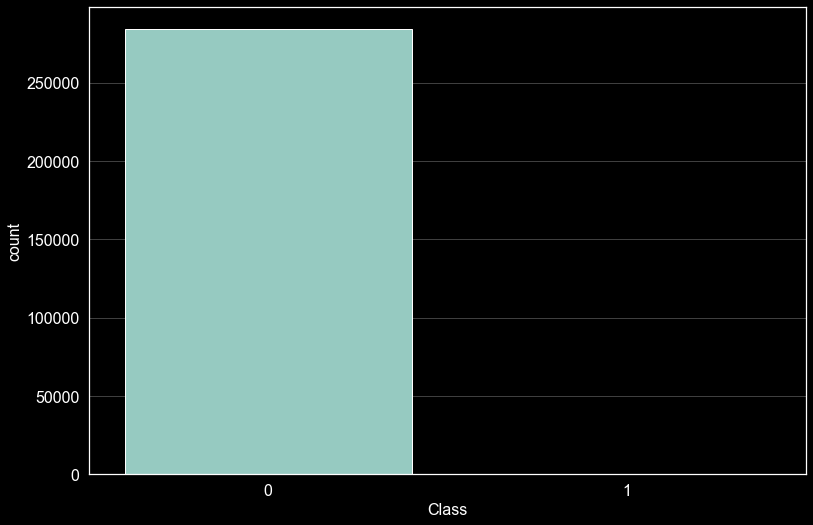

In [15]:
sns.countplot(data=df, x='Class')

In [16]:
df.loc[:, 'Class'].value_counts()
f'Fradulent transactions are {round(df.loc[:, "Class"].value_counts()[1]*100/len(df),2)}% of the total dataset'

0    284315
1       492
Name: Class, dtype: int64

'Fradulent transactions are 0.17% of the total dataset'

This is clearly a heavily inbalanced biclassification problem. This type of situation leads to the so called [**Accuracy Paradox**](https://en.wikipedia.org/wiki/Accuracy_paradox).

The essence of the paradox is that although the accuracy of the model (for the dominant class) is very high, it does not help with the predictive power of the model. 

There are times when it might be better to have lower accuracy in order to increase the predictive potency of the model. This effect may become more severe if no proper treatment of this imbalance takes place. 

The proper treatment includes techniques such as scaling the data, sampling techniques and (hyper)parameter tuning. We will mostly proble the data scaling techniques.

Let us first check some statistics for normal and fraudulent cases

- normal, they are highly non Gaussian with super bulky tails and the mean is much lower than std

In [17]:
df[df.Class==0].Amount.agg(['mean', 'std', 'skew', 'kurt'])

mean     88.291022
std     250.105092
skew     17.003147
kurt    846.736996
Name: Amount, dtype: float64

- fradulent, they are not severely non Gaussian,  the mean is half the std

In [18]:
df[df.Class==1].Amount.agg(['mean', 'std', 'skew', 'kurt'])

mean    122.211321
std     256.683288
skew      3.754477
kurt     17.745687
Name: Amount, dtype: float64

<Figure size 2400x1200 with 0 Axes>

<AxesSubplot:xlabel='Class', ylabel='Amount'>

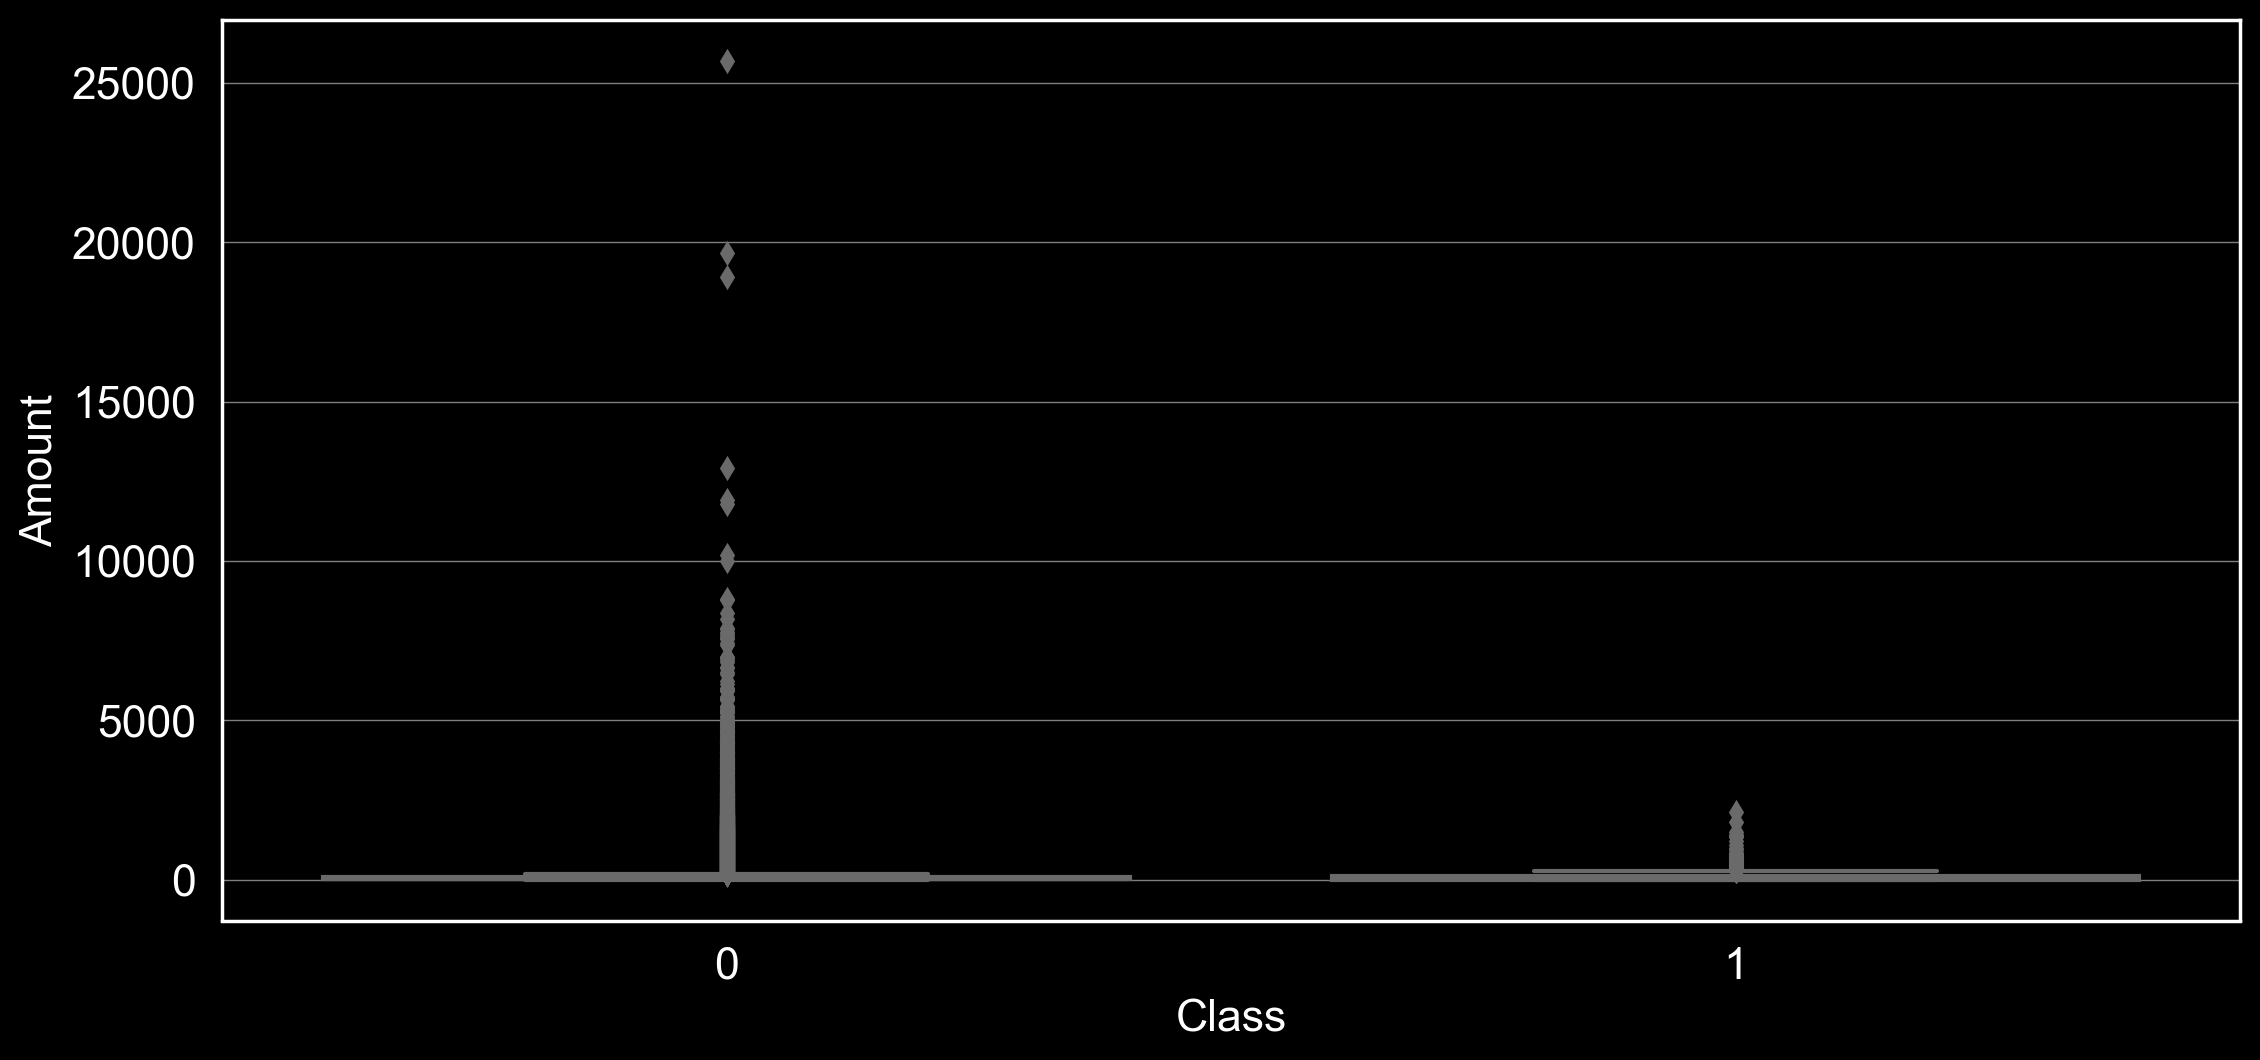

In [19]:
plt.figure(figsize=(12,6), dpi=200)
sns.boxplot(data=df, x='Class',y='Amount')

The box indicates the mean value of the amount and the line indicates the standard deviation

<AxesSubplot:xlabel='Class', ylabel='Amount'>

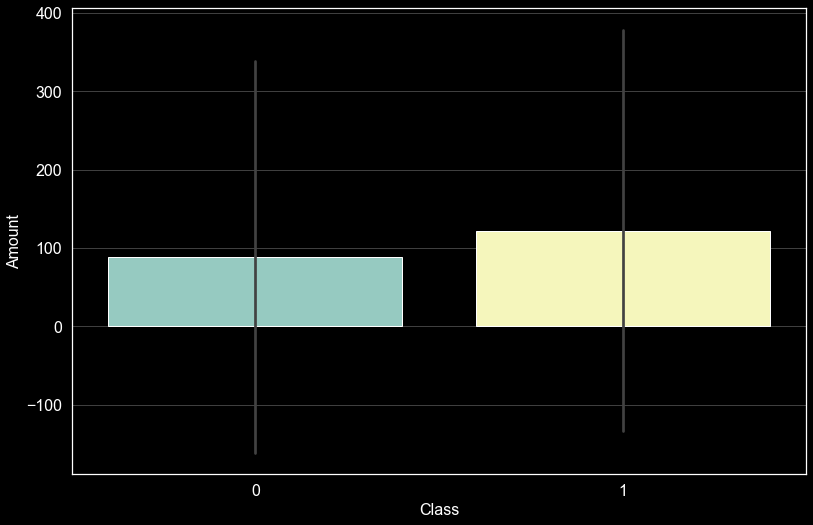

In [20]:
sns.barplot(data=df, x='Class', y='Amount', estimator=np.mean, ci='sd')

We observe that the fraudulent cases have a higher mean, which is something logical. Nevertheless, the standard deviation of both classses is practically the same.

Finally, we define as y the Class columns and all the rest features are packed in X

In [21]:
X = df.drop('Class', axis=1)
y = df.loc[:, 'Class']

# Estimators

## Estimator: SVM naive

### Data Preparation

We perform a standard train and split with 10% test data.
- This way of preprocessing the data, is obviously not really gonna work. Nevertheless we will follow through as a proof of concept.
- In general in order to save this method for imbalance classes we need to set stratify=True, in order for train_test_split to take into account the imbalance in the classes.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

### Classifier Train and Fit

We define the classifier

In [50]:
cls_naive = svm.SVC()

which we leave with its default settings:
- regulation parameter C=1.0
- kernel choice kernel='rbf' (nonlinear)
- class_weight=None equal treatment of the binary classes

We train the model

In [51]:
cls_naive.fit(X_train, y_train)

SVC()

the error can be ignored since it does note really affect the analysis

we save the model

In [52]:
save_object(path=Path('classifiers/naive.joblib'), obj=cls_naive)

### Classifier Inspection

Load the model

In [53]:
cls_naive = joblib.load(Path('classifiers/naive.joblib'))

Let us inspect the various fit info

In [97]:
estimator_fit_info(cls_naive, y, y_train, y_test)

,fraud,normal,fraud/normal,rows
y,492.0,284315.0,0.17,284807.0
y_train,442.0,255884.0,0.17,256326.0
y_test,50.0,28431.0,0.18,28481.0
class_weight,1.0,1.0,NaN,NaN
n_support,442.0,491.0,NaN,NaN


both classes were treated with equal weights and have almost the same ammount of support vectors.

Notice that the fraudulent cases:
1. Are almost the same as the number of support vectors.
2. Of the y_train are exactly the same number as the number of support vectors.

### Model Evaluation

First we calculate the predicted values

In [98]:
y_pred = cls_naive.predict(X_test)

Confusion matrix

In [99]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)
conf_mat

array([[28431,     0],
       [   50,     0]], dtype=int64)

The off-diagonal elements are the one that got mis-classified

In [100]:
off_diag_sum = np.sum(conf_mat) - np.trace(conf_mat)
off_diag_sum

50

Let us visualize this in more concrete manner

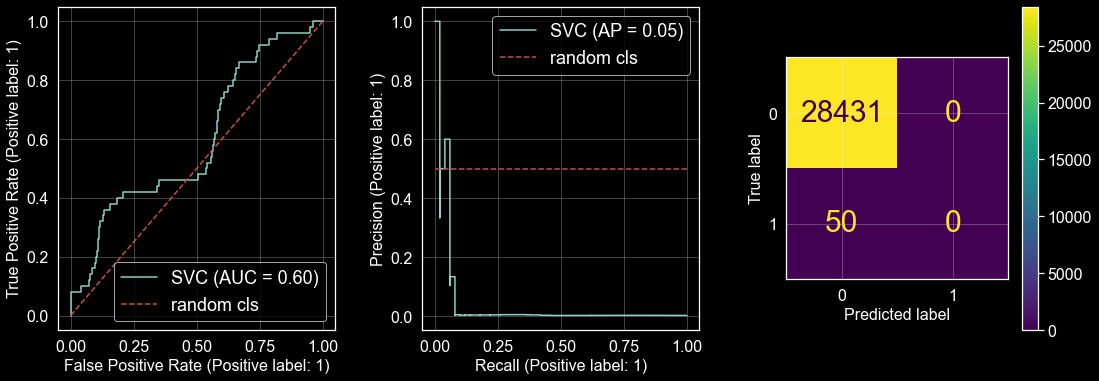

In [105]:
fig = metrics_plot(cls_naive, X_test, y_test, filename='naive_fig')

In [ ]:
cls_strat_metrics = metrics_calc(y_test, y_pred)

In [107]:
cls_strat_metrics[0]

,
Cls Metrics,
Accuracy,1.0
Precision,0.0
Recall,0.0
f1,0.0
Bal Accuracy,0.5
Av Precision,0.0
AUC,0.5
Matthews CC,0.0
Cohen KS,0.0


In [108]:
cls_strat_metrics[1]

,0,1
Cls Metrics Per Class,,
Precision,1.0,0.0
Recall,1.0,0.0
f1,1.0,0.0
Support,28431.0,50.0


As it is already evident form the plots the extreme imbalance is also implied by the 0 precision and recall in the per class summary. This is only reinforced by quantifying this with the dataframes with the metric scores. Thus this way of preprocessing data is not adequate for this extreme balance case.

## Estimator: SVM stratified

From now on we will our utility class clsfr to streamline the model building process.

In this case we make use of the stratify parameter 

In [109]:
cls_strat = clsfr(svm.SVC(), X=X, y=y, filename='stratified.joblib', stratify=y)
# cls_strat = load_object(path=Path('classifiers/stratified.joblib'))

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 21s
Function '__save' executed in 0s
Function '__init__' executed in 21s


Even after stratifying the train_and_split we have practilly the same ammount support vectors 

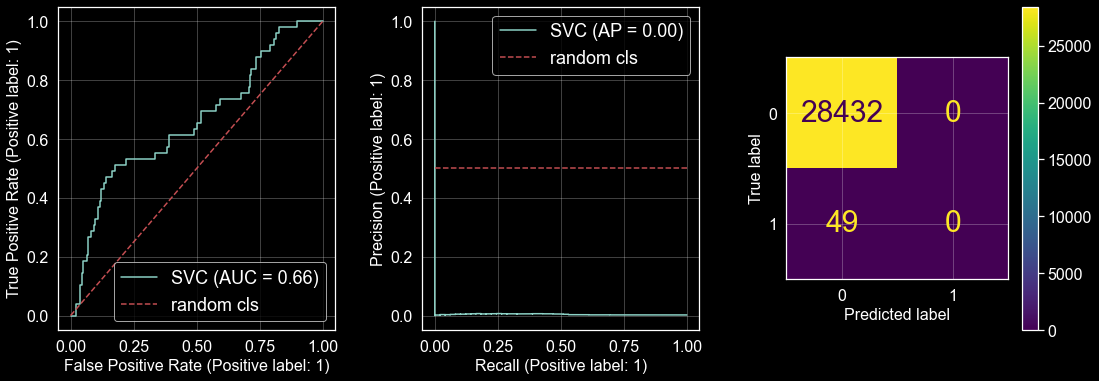

In [214]:
fig_strat = plot_metrics(cls_strat.estimator, cls_strat.X_test, cls_strat.y_test, filename='stratified_fig')

After stratifying the data split, the ROC curve seems better but the PRC is clearly worse.

The confusion matrix remains problematic with the TP.

Let us finally calculate the metrics although most of them will be undefined

In [114]:
cls_strat_metrics = metrics_calc(cls_strat.y_test, cls_strat.y_pred)

c:\Users\JustAnotherBot\miniconda3\envs\dataenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JustAnotherBot\miniconda3\envs\dataenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
cls_strat_metrics[0]

,
Cls Metrics,
Accuracy,1.0
Precision,0.0
Recall,0.0
f1,0.0
Bal Accuracy,0.5
Av Precision,0.0
AUC,0.5
Matthews CC,0.0
Cohen KS,0.0


Notice that accuracy is perfect, while the true accuracy "bal accuracy" is 0.5, i.e exactly half of its maximum value. Taking into account all other metrics the problem is clear, accuracy cannot be trusted.

In [116]:
cls_strat_metrics[1]

,0,1
Cls Metrics Per Class,,
Precision,1.0,0.0
Recall,1.0,0.0
f1,1.0,0.0
Support,28432.0,49.0


Notice that for class 0 (not fraud), there seems to be nothing wrong and all metrics have perfect scores, while for class 1 everything is 0.

Obviously just stratifying the data did not solve our problem. Next we try scaling the data.

## Estimator: SVM standarized

We standardize the data in order to "center" it so that we alleviate arbitrary scalings. All the variables should be on the same scale before applying classification otherwise a
feature with large values will dominate the result. 

This is exactly what it has been happening so far.

In [117]:
cls_scaled = clsfr(svm.SVC(), X=X, y=y, filename='standardized.joblib', transformer=StandardScaler)
# cls_scaled = load_object(path=Path('classifiers/stratified.joblib'))

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 360s
Function '__save' executed in 0s
Function '__init__' executed in 361s


Notice that after standardizing the data the fitting becomes much more power intensive. It is 6 mins compared to non scaled data which took only 21secs.

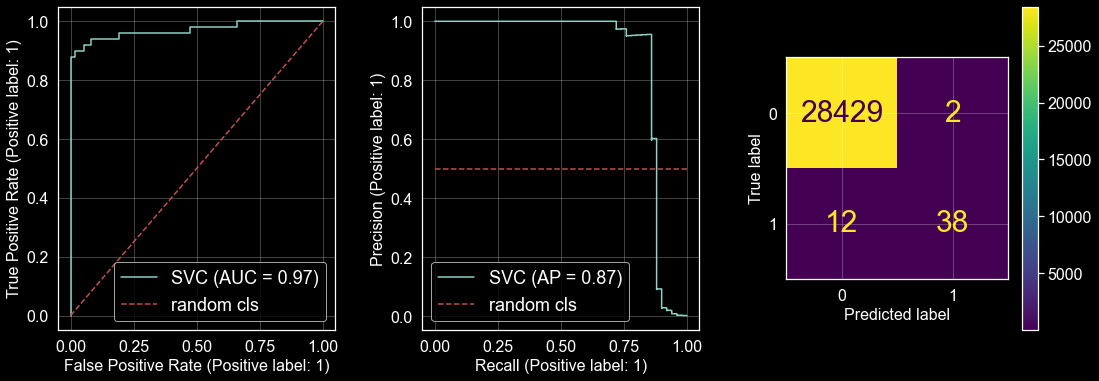

In [118]:
fig_scaled = metrics_plot(cls=cls_scaled.estimator, X_test=cls_scaled.X_test, y_test=cls_scaled.y_test, filename='standardized_fig')

It is immediately obvious that scaling the data by standardizing it, has a huge impact on the imbalance.
- The confusion matrix is properly calculated.
- The PRC curve attains a very good form.

Next we actually calculate the metrics

In [119]:
metrics_scaled = metrics_calc(y_test = cls_scaled.y_test, y_pred = cls_scaled.y_pred)

In [123]:
metrics_scaled[0].iloc[3:] # We neglect the rest cause they are not proper due to the accuracy paradox

,
Cls Metrics,
f1,0.84
Bal Accuracy,0.88
Av Precision,0.72
AUC,0.88
Matthews CC,0.85
Cohen KS,0.84


In [121]:
metrics_scaled[1]

,0,1
Cls Metrics Per Class,,
Precision,1.0,0.95
Recall,1.0,0.76
f1,1.0,0.84
Support,28431.0,50.00


Surprisingly just by standardizing the data we have a very good model at hand. We tried standardizing the data and stratifying it but the results where very slightly worse. Thus the most important factor is standardizing the data for the problem at hand.

## Estimator: SVM linear kernel

We standardize the data in order to "center" it so that we alleviate arbitrary scalings therein and check if imbalace is alleviated

In [22]:
cls_lin = clsfr(svm.SVC(kernel='linear'), X=X, y=y, filename='linear.joblib', transformer=StandardScaler)
# cls_scaled = load_object(path=Path('classifiers/stratified.joblib'))

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 4511s
Function '__save' executed in 0s
Function '__init__' executed in 4511s


Notice that after standardizing and changing the kernel to linear the data the fitting becomes much much more power intensive. It is 75 mins, which is about 13X more than default rbf kernel we have been using so far.

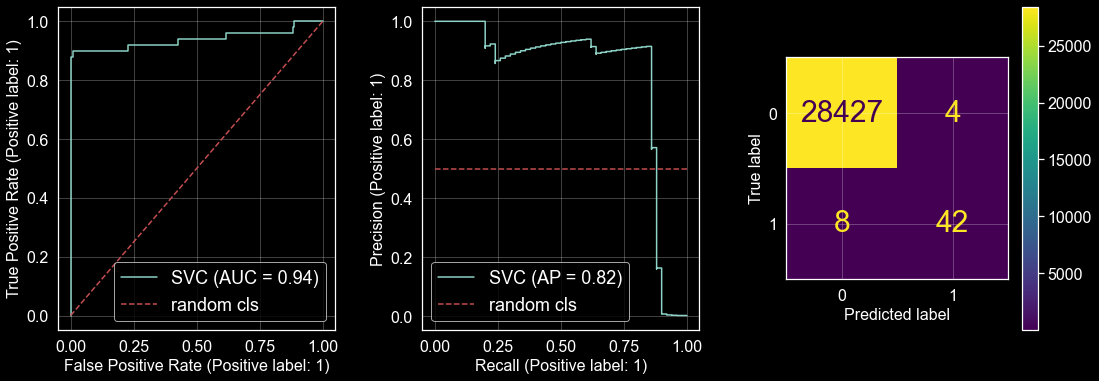

In [23]:
fig_lin = metrics_plot(cls=cls_lin.estimator, X_test=cls_lin.X_test, y_test=cls_lin.y_test, filename='lin_fig')

The model seems to perform well, but not better than the rbf kernel

In [24]:
metrics_lin = metrics_calc(y_test = cls_lin.y_test, y_pred = cls_lin.y_pred)

In [26]:
metrics_lin[0].iloc[3:] # We neglect the rest cause they are not proper due to the accuracy paradox

,
Cls Metrics,
f1,0.87
Bal Accuracy,0.92
Av Precision,0.77
AUC,0.92
Matthews CC,0.88
Cohen KS,0.87


In [27]:
metrics_lin[1]

,0,1
Cls Metrics Per Class,,
Precision,1.0,0.91
Recall,1.0,0.84
f1,1.0,0.87
Support,28431.0,50.00


Overall decent performance but very costly fitting. The rbf kernel seems as a much better choice.

## Estimator: SVM quadratic kernel

We choose the polyonimal kernel and try it for a power=2

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 47s
Function '__metrics_plot' executed in 1s
Function '__save' executed in 0s
Function '__init__' executed in 50s


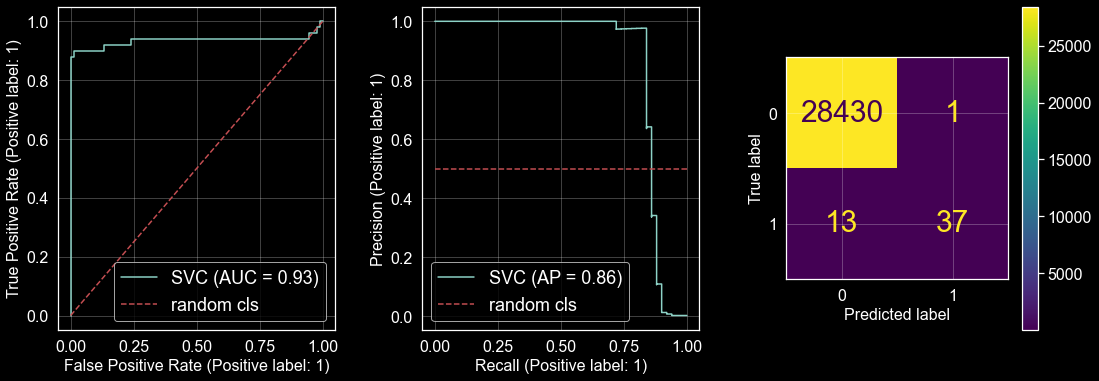

In [41]:
cls_quad = clsfr(svm.SVC(kernel='poly', degree=2), X=X, y=y, filename='quad', transformer=StandardScaler)
# cls_scaled = load_object(path=Path('classifiers/stratified.joblib'))

Apparently the poly kernel is ultra fast. The whole process took only ~1 min and the results seem to be very close to the rbf kernel.

The model seems to perform very well. Most certainly better than the linear kernel.

In [ ]:
cls_quad.m

In [ ]:
metrics_lin = metrics_calc(y_test = cls_lin.y_test, y_pred = cls_lin.y_pred)

In [ ]:
metrics_lin[0].iloc[3:] # We neglect the rest cause they are not proper due to the accuracy paradox

,
Cls Metrics,
f1,0.87
Bal Accuracy,0.92
Av Precision,0.77
AUC,0.92
Matthews CC,0.88
Cohen KS,0.87


In [ ]:
metrics_lin[1]

,0,1
Cls Metrics Per Class,,
Precision,1.0,0.91
Recall,1.0,0.84
f1,1.0,0.87
Support,28431.0,50.00


Overall decent performance but very costly fitting. The rbf kernel seems as a much better choice.

In [ ]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 63s
Function '__metrics_plot' executed in 3s
Function '__save' executed in 0s
Function '__init__' executed in 68s


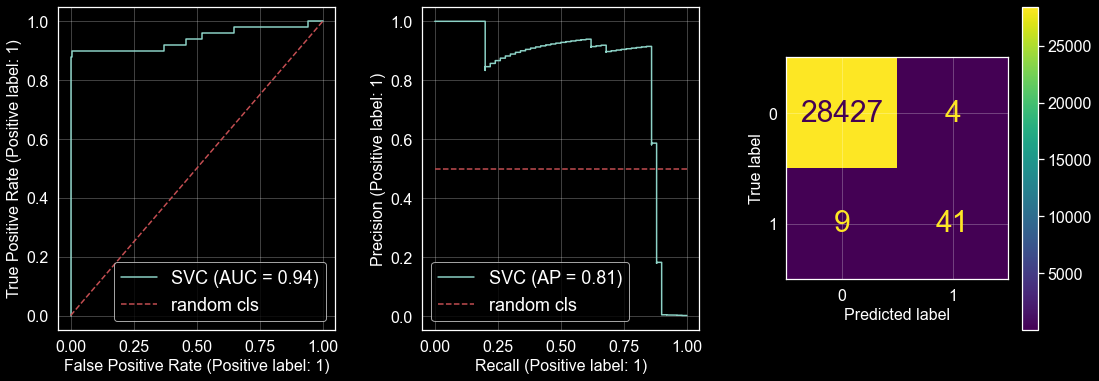

In [61]:
cls_poly_1 = clsfr(svm.SVC(kernel='poly', degree=1), X=X, y=y, filename='poly_1', transformer=StandardScaler)

In [62]:
cls_poly_1.metrics_calc()

Function 'metrics_calc' executed in 0s


,
Cls Metrics,
Accuracy,1.00
Precision,0.91
Recall,0.82
f1,0.86
Bal Accuracy,0.91
Av Precision,0.75
AUC,0.91
Matthews CC,0.86
Cohen KS,0.86


In [63]:
cls_poly_1.metrics_calc_class()

Function 'metrics_calc_class' executed in 0s


,0,1
Cls Metrics Per Class,,
Precision,1.0,0.91
Recall,1.0,0.82
f1,1.0,0.86
Support,28431.0,50.00


In [64]:
cls_poly_1.fit_info()

Function 'fit_info' executed in 0s


,fraud,normal,fraud/normal,rows
y,492.0,284315.0,0.17,284807.0
y_train,442.0,255884.0,0.17,256326.0
y_test,50.0,28431.0,0.18,28481.0
class_weight,1.0,1.0,NaN,NaN
n_support,219.0,237.0,NaN,NaN


Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 50s
Function '__metrics_plot' executed in 1s
Function '__save' executed in 0s
Function '__init__' executed in 52s


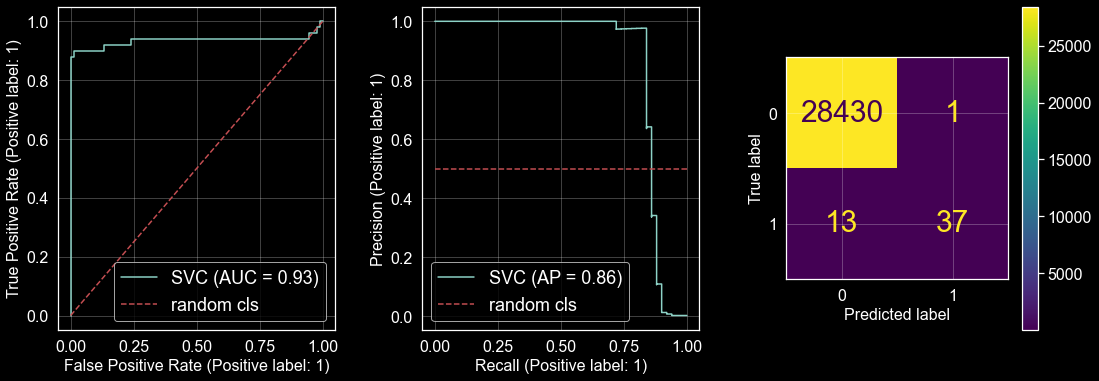

In [48]:
cls_poly_2 = clsfr(svm.SVC(kernel='poly', degree=2), X=X, y=y, filename='poly_2', transformer=StandardScaler)

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 137s
Function '__metrics_plot' executed in 2s
Function '__save' executed in 0s
Function '__init__' executed in 141s


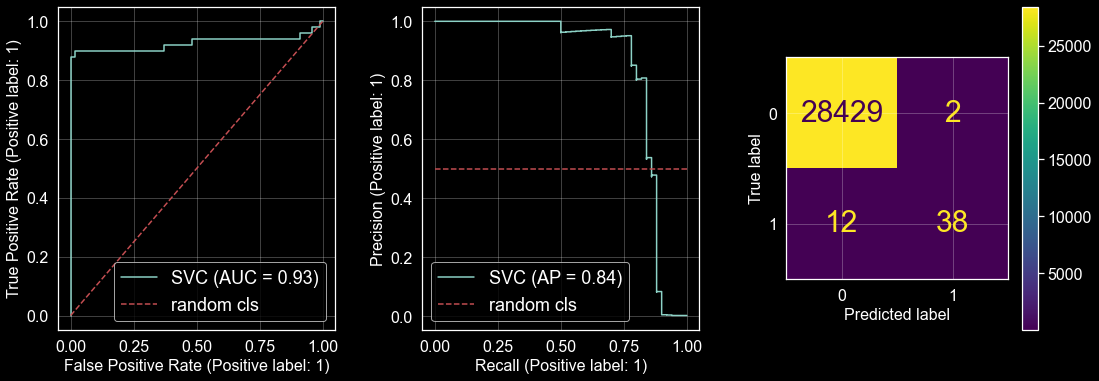

In [44]:
cls_poly_3 = clsfr(
        svm.SVC(kernel='poly', degree=3), 
        X=X, 
        y=y, 
        filename='poly_3', 
        transformer=StandardScaler
    )

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 178s
Function '__metrics_plot' executed in 3s
Function '__save' executed in 0s
Function '__init__' executed in 182s


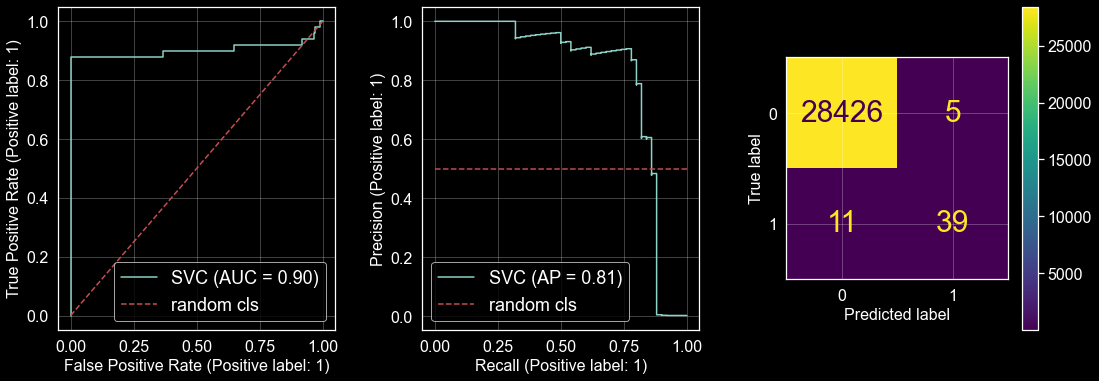

In [46]:
cls_poly_4 = clsfr(svm.SVC(kernel='poly', degree=4), X=X, y=y, filename='poly_4', transformer=StandardScaler)

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 13s
Function '__metrics_plot' executed in 2s
Function '__save' executed in 0s
Function '__init__' executed in 18s


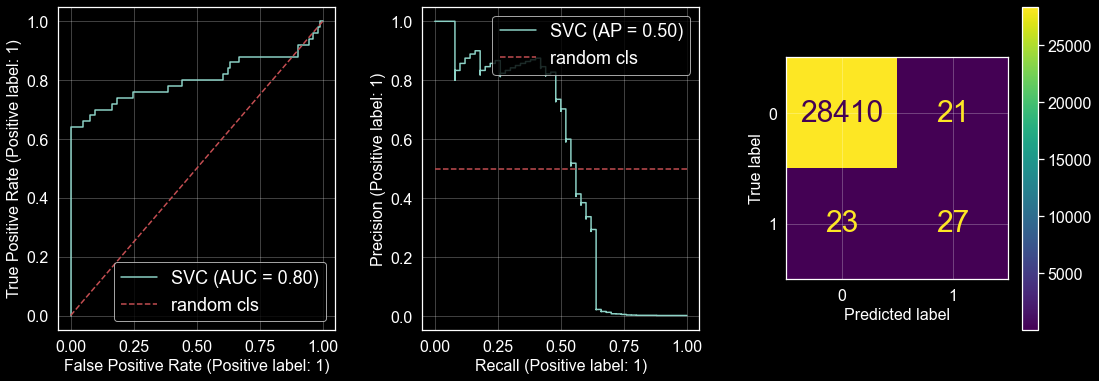

In [67]:
cls_sigmoid = clsfr(svm.SVC(C=1, kernel='sigmoid'), X=X, y=y, filename='sigmoid', transformer=StandardScaler)

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 401s
Function '__metrics_plot' executed in 38s
Function '__save' executed in 0s
Function '__init__' executed in 440s


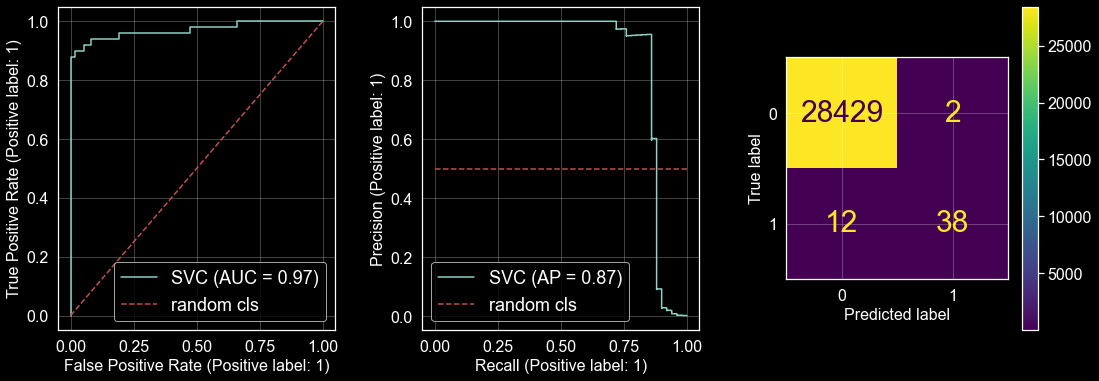

In [70]:
cls_g_auto = clsfr(svm.SVC(gamma='auto'), X=X, y=y, filename='g_auto', transformer=StandardScaler)

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 1687s
Function '__metrics_plot' executed in 42s
Function '__save' executed in 0s
Function '__init__' executed in 1730s


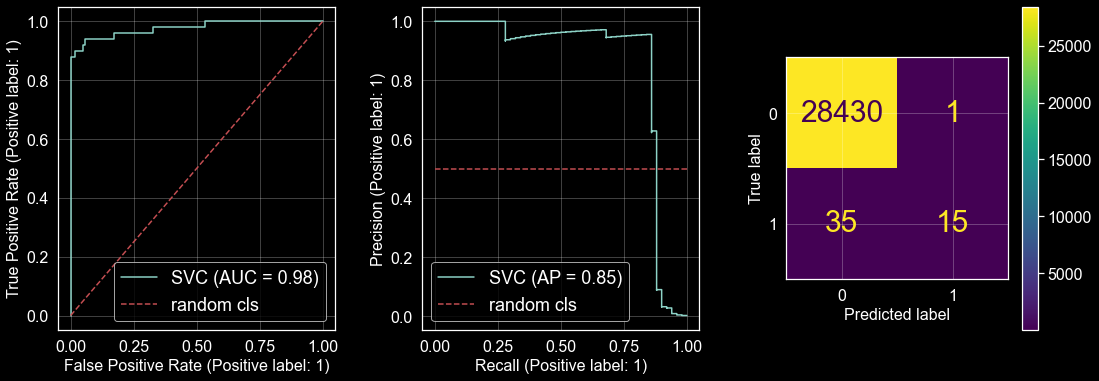

In [71]:
cls_c_01 = clsfr(svm.SVC(C=0.1), X=X, y=y, filename='c_01', transformer=StandardScaler)

## Estimator: Logistic Regression

In [261]:
cls_log_res = clsfr(LogisticRegression(), X=X, y=y, filename='log_res.joblib', transformer=StandardScaler)
# cls_strat_scaled = load_object(path=Path('classifiers/strat_scaled.joblib'))

Function '__data_prep' executed in 0s
Function '__fit_pred' executed in 3s
Function '__save' executed in 0s
Function '__init__' executed in 4s


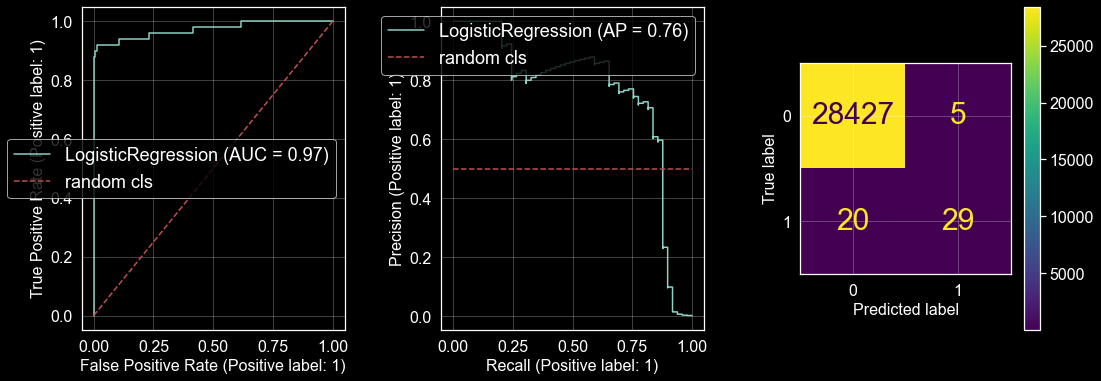

In [262]:
fig_log_res = metrics_plot(cls=cls_log_res.estimator, X_test=cls_log_res.X_test, y_test=cls_log_res.y_test, filename='cls_log_res_fig')

In [263]:
metrics_log_res = metrics_calc(y_test = cls_log_res.y_test, y_pred = cls_log_res.y_pred)

In [266]:
metrics_log_res[0]

,
Cls Metrics,
Accuracy,1.00
Precision,0.85
Recall,0.59
f1,0.70
Bal Accuracy,0.80
Av Precision,0.51
AUC,0.80
Matthews CC,0.71
Cohen KS,0.70


In [267]:
metrics_log_res[1]

,0,1
Cls Metrics Per Class,,
Precision,1.0,0.85
Recall,1.0,0.59
f1,1.0,0.70
Support,28432.0,49.00


Logistic Regression with the default args performed worse than SVC.

# Summary